In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d

In [15]:
fbar_prefix_list = [
                    # ('fid-Z0', 'lvl5-Z0'),
                    # ('fid-Z0-wB', 'lvl5-Z0-withB'),
                    # ('fb01-Z0', 'lvl5-fbar01-Z0'),
                    # ('fb01-vp03-Z0', 'lvl5-fbar01-vphi03-Z0'),
                    # ('fb01-vp04-Z0', 'lvl5-fbar01-vphi04-Z0'),
                    # ('RC20-Z0', 'lvl5-RC20-Z0'),
                    ('fb006-vp04-Z0', 'lvl5-fbar006-vphi04-Z0'),
                    ('fb006-vp04-Z0-l4', 'lvl4-fbar006-vphi04-Z0'),
                    ]

fbar_list = [l[0] for l in fbar_prefix_list]
prefix_list = [l[1] for l in fbar_prefix_list]

idx_list = np.arange(0, 2000+1, 50)

sn_fbar = {}
for fbar,prefix in zip(fbar_list, prefix_list):
    print('loading fbar=', fbar)
    sn_fbar[fbar] = {}
    sn_fbar[fbar]['idx_list'] = []
    
    outbase = prefix + '/output'
    
    for idx in tqdm(idx_list):
        try:
            sn_fbar[fbar][idx] = arepo.Snapshot(outbase, idx, combineFiles=True)
            sn_fbar[fbar]['idx_list'].append(idx)
        except:
            break
    
    sn_fbar[fbar]['idx_list'] = np.array(sn_fbar[fbar]['idx_list'])

loading fbar= fb006-vp04-Z0


100%|██████████| 41/41 [00:03<00:00, 12.33it/s]


loading fbar= fb006-vp04-Z0-l4


 59%|█████▊    | 24/41 [00:02<00:02,  8.47it/s]


# stellar mass buildup and half mass radius

In [3]:
def get_stellar_mass(sn):
    if sn.NumPart_Total[4] == 0:
        return 0.0
    
    is_star = sn.GFM_StellarFormationTime > 0
    if np.sum(is_star) == 0:
        return 0.0
    
    return np.sum(sn.part4.mass.value[is_star])

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

def get_halfmass_radius(sn):
    pot_min = 0
    for pt in [0, 1, 4]:
        if sn.NumPart_Total[pt] == 0:
            continue
        part = getattr(sn, 'part'+str(pt))
        if np.min(part.pot.value) < pot_min:
            center = part.pos.value[np.argmin(part.pot.value)]
            pot_min = np.min(part.pot.value)
    
    if sn.NumPart_Total[4] == 0:
        return np.nan
    
    pos = sn.part4.pos.value - center
    mass = sn.part4.mass.value
    r = np.linalg.norm(pos, axis=1)
    
    is_star = sn.part4.GFM_StellarFormationTime > 0
    
    rhalf = weighted_median(r[is_star], mass[is_star])
    return rhalf

In [16]:
stmass = {}
for fbar in fbar_list:
    stmass[fbar] = {}
    stmass[fbar]['Time'] = []
    stmass[fbar]['StellarMass'] = []
    stmass[fbar]['HalfMassRadius'] = []
    for idx in sn_fbar[fbar]['idx_list']:
        stmass[fbar]['Time'].append(sn_fbar[fbar][idx].Time.value)
        stmass[fbar]['StellarMass'].append(get_stellar_mass(sn_fbar[fbar][idx]))
        stmass[fbar]['HalfMassRadius'].append(get_halfmass_radius(sn_fbar[fbar][idx]))
    
    for k in stmass[fbar].keys():
        stmass[fbar][k] = np.array(stmass[fbar][k])

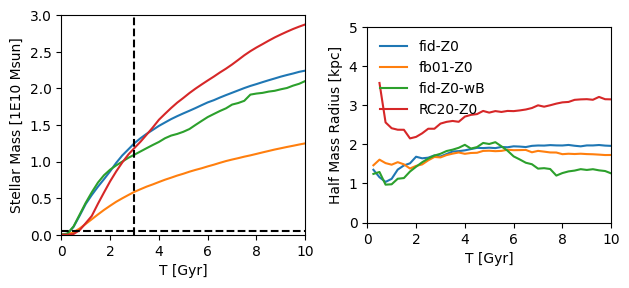

In [9]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = ['fid-Z0', 'fb01-Z0', 'fid-Z0-wB', 'RC20-Z0']

for fbar in fbar_plot:
    ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

ax[0].set(xlim=(0, 10), ylim=(0, 3))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(0.05, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, 5))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(3)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()

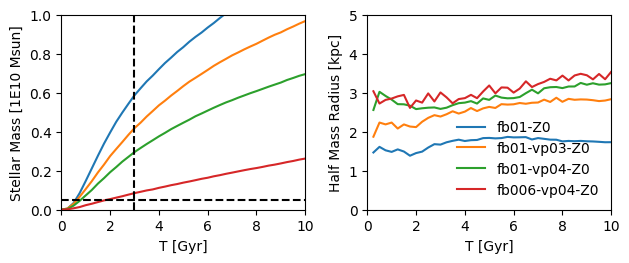

In [ ]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = ['fb01-Z0', 'fb01-vp03-Z0', 'fb01-vp04-Z0', 'fb006-vp04-Z0']

for fbar in fbar_plot:
    ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

ax[0].set(xlim=(0, 10), ylim=(0, 1))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(5e8/1e10, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, 5))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(8)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()

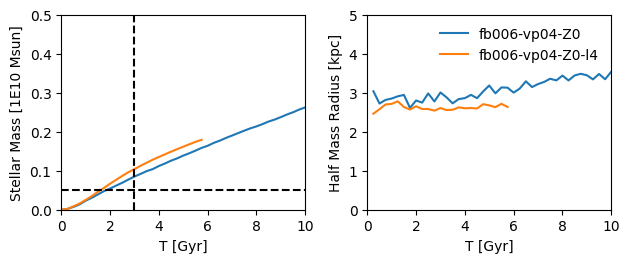

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = ['fb006-vp04-Z0', 'fb006-vp04-Z0-l4']

for fbar in fbar_plot:
    ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

ax[0].set(xlim=(0, 10), ylim=(0, 0.5))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(5e8/1e10, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, 5))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(16)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()